In [1]:
import numpy as np
import pandas as pd
import cbsodata
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [2]:
#toc = pd.DataFrame(cbsodata.get_table_list())
#toc
info = cbsodata.get_info('70895ned') # Returns a dict with info
[info.get(key) for key in ['Title', 'Modified']]

['Overledenen; geslacht en leeftijd, per week', '2021-07-30T02:00:00']

In [3]:
data = pd.DataFrame(cbsodata.get_data('70895ned'))
data.dropna(subset = ["Overledenen_1"], inplace=True)
df=data[data.Perioden.str.contains('week')]
df=df[df.Perioden.str.contains('1995 week 0')==False].reset_index(drop=True)
df.iloc[1400:1410]

,ID,Geslacht,LeeftijdOp31December,Perioden,Overledenen_1
1400,1427,Totaal mannen en vrouwen,Totaal leeftijd,2021 week 22,3005.0
1401,1428,Totaal mannen en vrouwen,Totaal leeftijd,2021 week 23,2877.0
1402,1429,Totaal mannen en vrouwen,Totaal leeftijd,2021 week 24,2862.0
1403,1430,Totaal mannen en vrouwen,Totaal leeftijd,2021 week 25,2656.0
1404,1431,Totaal mannen en vrouwen,Totaal leeftijd,2021 week 26,2768.0
1405,1432,Totaal mannen en vrouwen,Totaal leeftijd,2021 week 27,2814.0
1406,1433,Totaal mannen en vrouwen,Totaal leeftijd,2021 week 28,2833.0
1407,1434,Totaal mannen en vrouwen,Totaal leeftijd,2021 week 29,2791.0
1408,1436,Totaal mannen en vrouwen,0 tot 65 jaar,1995 week 1,476.0
1409,1437,Totaal mannen en vrouwen,0 tot 65 jaar,1995 week 2,511.0


In [4]:
df_clean = df.drop(columns = ['ID'])
df_clean['to_first_week']=df_clean.Perioden.str.contains('dag') & df_clean.Perioden.str.contains('week 1')
df_clean['to_last_week']=df_clean.Perioden.str.contains('dag') & df_clean.Perioden.shift(-1).str.contains('week 0')
df_clean['partial_week']=df_clean.Perioden.str.contains('dag')
df_clean.loc[df_clean['to_first_week'] == True, 'deaths'] = df_clean['Overledenen_1'].shift(+1) + df_clean['Overledenen_1'] 
df_clean.loc[df_clean['to_last_week'] == True, 'deaths'] = df_clean['Overledenen_1'].shift(-1) + df_clean['Overledenen_1'] 
df_clean.loc[df_clean['partial_week'] == False, 'deaths'] = df_clean['Overledenen_1']
df_clean = df_clean.dropna(subset = ["deaths"]).reset_index(drop=True)
df_clean[['year','week']] = df_clean.Perioden.str.split("week",expand=True)
df_clean['week'] = df_clean.week.str.extract('(\d+)')
df_clean['year'] = df_clean.year.str.extract('(\d+)')
df_clean = df_clean.drop(columns = ['Overledenen_1','to_first_week','to_last_week','partial_week'])
df_clean = df_clean.rename(columns={"LeeftijdOp31December": "age", "Geslacht": "gender"})
df_clean = df_clean[['Perioden','gender','age','year','week','deaths']]

#remove this line to get the full time period
df_clean=df_clean[df_clean.Perioden >= '2010'].reset_index(drop=True)

df_clean['covid_year']=df_clean['year'] >= '2020'
df_clean.loc[df_clean['covid_year'] == False, 'covid_year'] = '2011-2019 +/- SD'
df_clean.loc[df_clean['covid_year'] == True, 'covid_year'] = df_clean['year']

df_clean.iloc[0:10]

,Perioden,gender,age,year,week,deaths,covid_year
0,2010 week 1,Totaal mannen en vrouwen,Totaal leeftijd,2010,1,2767.0,2011-2019 +/- SD
1,2010 week 2,Totaal mannen en vrouwen,Totaal leeftijd,2010,2,2830.0,2011-2019 +/- SD
2,2010 week 3,Totaal mannen en vrouwen,Totaal leeftijd,2010,3,2846.0,2011-2019 +/- SD
3,2010 week 4,Totaal mannen en vrouwen,Totaal leeftijd,2010,4,2865.0,2011-2019 +/- SD
4,2010 week 5,Totaal mannen en vrouwen,Totaal leeftijd,2010,5,2858.0,2011-2019 +/- SD
5,2010 week 6,Totaal mannen en vrouwen,Totaal leeftijd,2010,6,2831.0,2011-2019 +/- SD
6,2010 week 7,Totaal mannen en vrouwen,Totaal leeftijd,2010,7,2900.0,2011-2019 +/- SD
7,2010 week 8,Totaal mannen en vrouwen,Totaal leeftijd,2010,8,2929.0,2011-2019 +/- SD
8,2010 week 9,Totaal mannen en vrouwen,Totaal leeftijd,2010,9,2757.0,2011-2019 +/- SD
9,2010 week 10,Totaal mannen en vrouwen,Totaal leeftijd,2010,10,2760.0,2011-2019 +/- SD


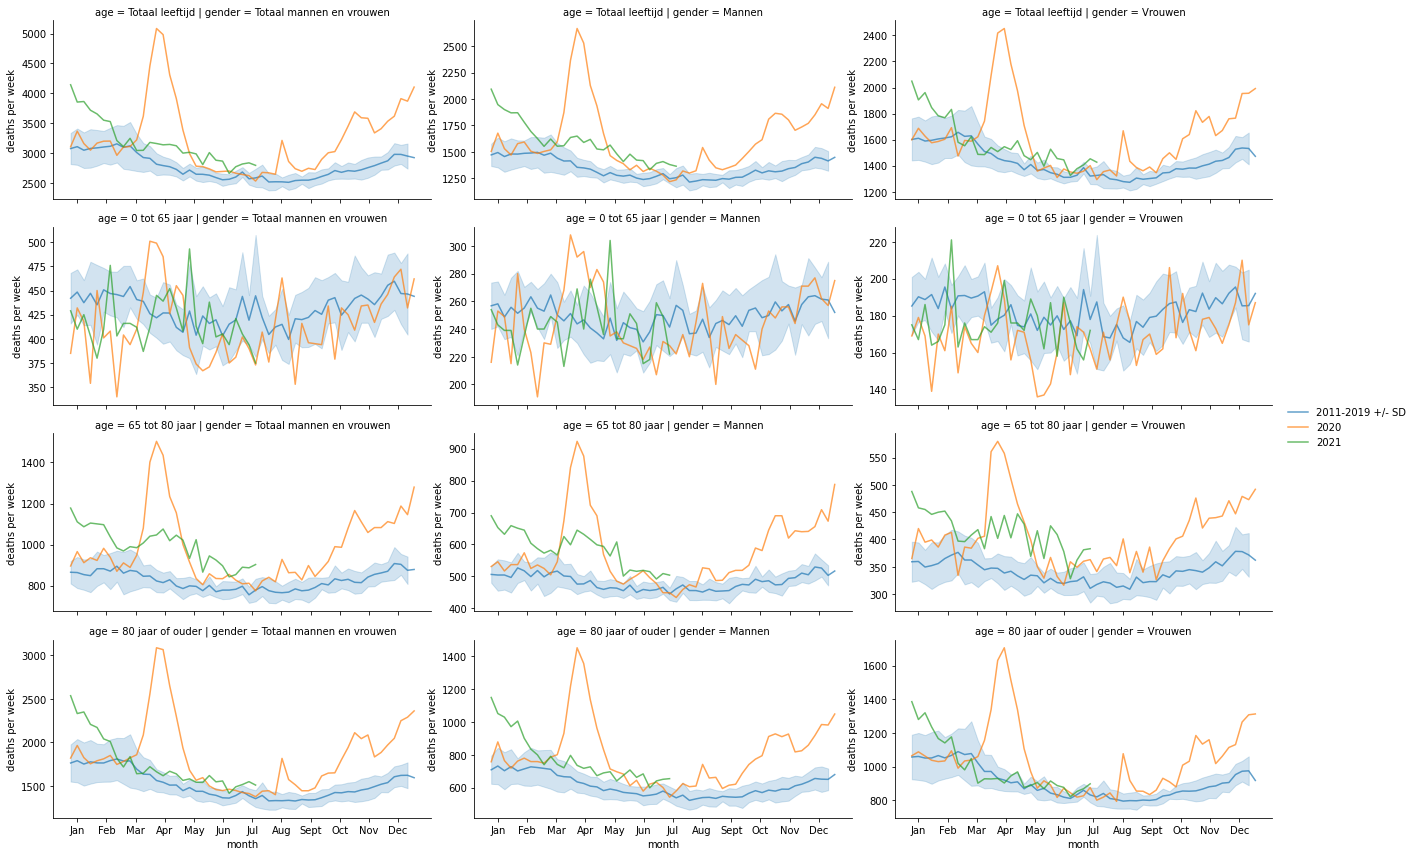

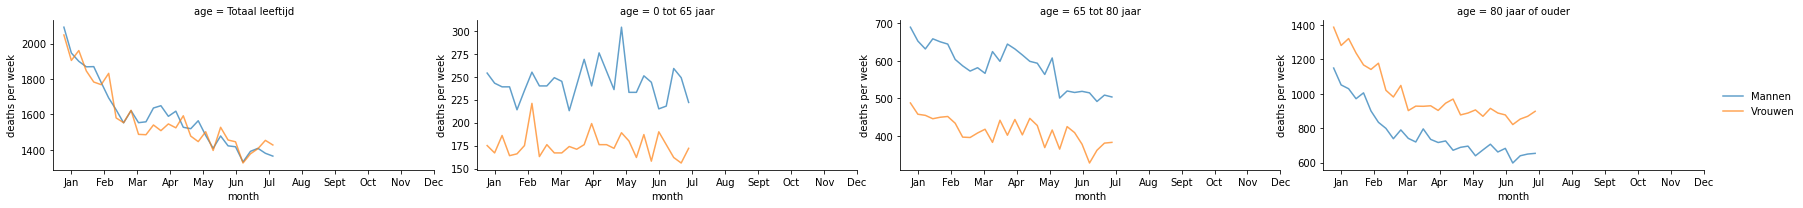

In [5]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

g = sns.FacetGrid(df_clean, col="gender", hue="covid_year", row='age', aspect=2,sharey=False)
g.map(sns.lineplot, 'week', 'deaths', alpha=.7, estimator='mean', ci='sd')
g.set(xlabel="month", ylabel = "deaths per week", xticks=np.arange(1, 53,(53/12) ), xticklabels=months)
g.add_legend(title = '')
g.savefig('naar_Geslacht_leeftijd.png', dpi=300, bbox_inches='tight', facecolor='white')

g = sns.FacetGrid(df_clean.query("year == '2021' & gender !='Totaal mannen en vrouwen'"), col="age", hue="gender", aspect=2,sharey=False)
g.map(sns.lineplot, 'week', 'deaths', alpha=.7)
g.set(xlabel="month", ylabel = "deaths per week", xticks=np.arange(1, 53,(53/12) ), xticklabels=months)
g.add_legend(title = '')
g.savefig('2021_leeftijd.png', dpi=300, bbox_inches='tight', facecolor='white')

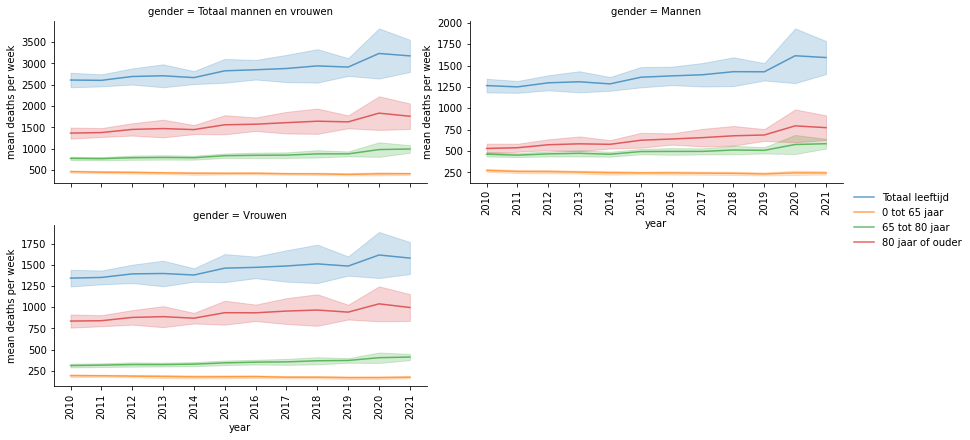

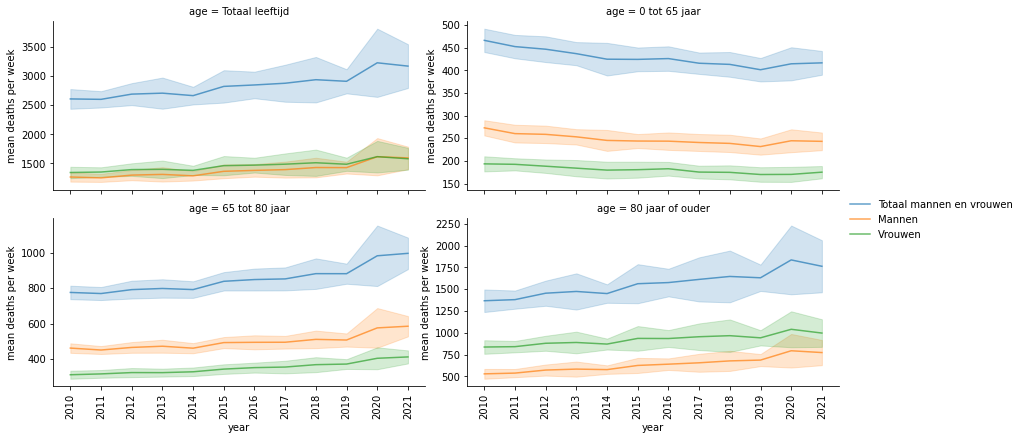

In [6]:
g = sns.FacetGrid(df_clean, col="gender", hue="age", col_wrap=2, aspect=2,sharey=False)
g.map(sns.lineplot, 'year', 'deaths', alpha=.7, estimator='mean', ci='sd')
g.set(xlabel="year", ylabel = "mean deaths per week")
g.set_xticklabels(rotation=90)
g.add_legend(title = '')
g.savefig('perjaar_Geslacht.png', dpi=300, bbox_inches='tight', facecolor='white')

g = sns.FacetGrid(df_clean, col="age", hue="gender",col_wrap=2, aspect=2,sharey=False)
g.map(sns.lineplot, 'year', 'deaths', alpha=.7, estimator='mean', ci='sd')
g.set(xlabel="year", ylabel = "mean deaths per week")
g.set_xticklabels(rotation=90)
g.add_legend(title = '')
g.savefig('perjaar_leeftijd.png', dpi=300, bbox_inches='tight', facecolor='white')

In [7]:
leeftijd='Totaal leeftijd'
#leeftijd='0 tot 65 jaar'
#leeftijd='65 tot 80 jaar'
#leeftijd='80 jaar of ouder'
sex='Totaal mannen en vrouwen'
#sex='Mannen'
#sex='Vrouwen'

df_circle=df_clean[(df_clean.age == leeftijd) & (df_clean.gender == sex)]
df_circle = df_circle.groupby('Perioden').sum().squeeze()
df_circle

Perioden
2010 week 1     2767.0
2010 week 10    2760.0
2010 week 11    2686.0
2010 week 12    2687.0
2010 week 13    2586.0
                 ...  
2021 week 5     3653.0
2021 week 6     3548.0
2021 week 7     3525.0
2021 week 8     3206.0
2021 week 9     3105.0
Name: deaths, Length: 603, dtype: float64

In [8]:
deaths_per_year = pd.DataFrame(columns=range(2010, 2021+1), index=pd.RangeIndex(1, 53+1, name='week'))

for Perioden, deaths in df_circle.iteritems():
    year = int(Perioden[0:4])
    week = int(Perioden[9:12])
    deaths_per_year.loc[week, year] = deaths
    
deaths_per_year

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
week,,,,,,,,,,,,
1,2767.0,2917.0,2930.0,2947.0,2766.0,3255.0,3173.0,3568.0,3343.0,3062.0,3103.0,4142.0
2,2830.0,2819.0,2773.0,3038.0,2819.0,3429.0,3075.0,3637.0,3359.0,3262.0,3364.0,3852.0
3,2846.0,2624.0,2785.0,3011.0,2740.0,3377.0,3062.0,3487.0,3364.0,3152.0,3157.0,3861.0
4,2865.0,2620.0,2789.0,3082.0,2710.0,3353.0,3201.0,3626.0,3322.0,3179.0,3046.0,3715.0
5,2858.0,2728.0,2815.0,3192.0,2708.0,3322.0,3103.0,3574.0,3403.0,3139.0,3164.0,3653.0
6,2831.0,2675.0,3034.0,3143.0,2855.0,3272.0,3036.0,3446.0,3513.0,3183.0,3196.0,3548.0
7,2900.0,2621.0,3089.0,3033.0,2796.0,3311.0,3027.0,3417.0,3660.0,3254.0,3198.0,3525.0
8,2929.0,2651.0,3035.0,3211.0,2753.0,3381.0,3319.0,3328.0,3691.0,3220.0,2959.0,3206.0
9,2757.0,2686.0,3061.0,3170.0,2713.0,3207.0,3185.0,3152.0,3937.0,3065.0,3098.0,3105.0


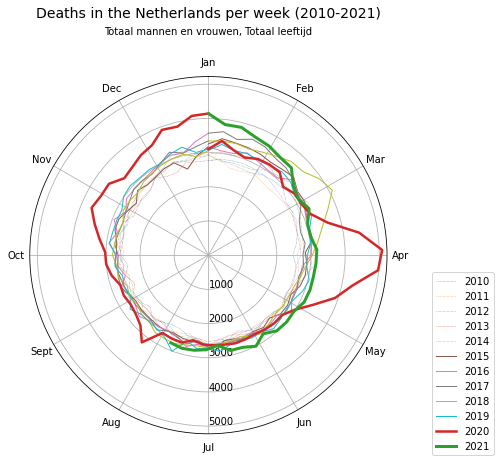

In [9]:
def data_for_year(y):
    year = deaths_per_year[y].dropna().to_numpy()
    if y == 2021:
        num_weeks = len(year)
        day_of_the_year = num_weeks*7 + 3 # ex. week 46 -> november 15 -> day 319
        theta = np.linspace(0, (day_of_the_year/365)*2*np.pi, num_weeks)
    else:
        # append first week of next year for correct radial plotting
        year = np.append(year, deaths_per_year.loc[1, y+1])
        theta = np.linspace(0, 2*np.pi, len(year))
    return (theta, year)

def plot_year(ax, y, **kwargs):
    ax.plot(*data_for_year(y), label=f"{y}", **kwargs)

def setup_polar_plot(figsize=(8, 6), constrained_layout=True):
    fig = plt.figure(figsize=figsize, constrained_layout=constrained_layout)
    ax = fig.add_subplot(111, projection='polar')

    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_xticks(np.arange(0, 2*np.pi, np.pi/6))
    ax.set_xticklabels(months)

    ax.set_rlabel_position(180)
#    ax.set_yticklabels(['1000', '2000', '3000', '4000', '5000', ''])

    return fig, ax

fig, ax = setup_polar_plot()
plot_year(ax, 2010, linewidth=0.5, linestyle='dotted')
plot_year(ax, 2011, linewidth=0.5, linestyle='dotted')
plot_year(ax, 2012, linewidth=0.5, linestyle='dotted')
plot_year(ax, 2013, linewidth=0.5, linestyle='dotted')
plot_year(ax, 2014, linewidth=0.5, linestyle='dotted')
plot_year(ax, 2015, linewidth=1)
plot_year(ax, 2016, linewidth=1)
plot_year(ax, 2017, linewidth=1)
plot_year(ax, 2018, linewidth=1)
plot_year(ax, 2019, linewidth=1)
plot_year(ax, 2020, color='tab:red', linewidth=2.5)
plot_year(ax, 2021, color='tab:green', linewidth=3)

#plot_year(ax, 2011, color='tab:gray', linewidth=0.5)
#plot_year(ax, 2012, color='tab:gray', linestyle='dotted')
#plot_year(ax, 2013, color='tab:gray', linestyle='dashed')
#plot_year(ax, 2014, color='tab:gray', linestyle='dashdot')
#plot_year(ax, 2015, color='tab:gray')
#plot_year(ax, 2016, color='tab:blue', linestyle='dashdot')
#plot_year(ax, 2017, color='tab:blue')
#plot_year(ax, 2018, color='tab:green')
#plot_year(ax, 2019, color='tab:orange')
#plot_year(ax, 2020, color='tab:red', linewidth=3)

#ax.set_rmax(5500)
fig.legend(loc='lower right')
fig.suptitle("Deaths in the Netherlands per week (2010-2021)", fontsize=14, y=1.04)
ax.set_title(f"{sex}, {leeftijd}", fontsize=10, y=1.1)

plt.savefig('sterfte_perjaar.png', dpi=300, bbox_inches='tight', facecolor='white')

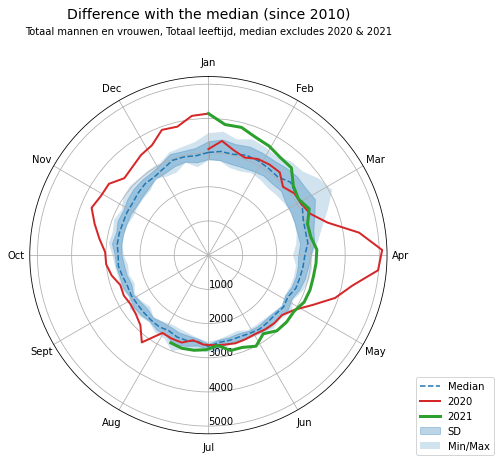

In [10]:
years = deaths_per_year.iloc[:, :-2] # excluding 2021

mean = years.mean(skipna=True,axis=1)
mean[53] = mean[1]

median = years.median(skipna=True,axis=1)
median[53] = median[1]

min = years.min(axis=1)
min[53] = min[1]

max = years.max(axis=1)
max[53] = max[1]

sd = years.std(axis=1)
sd[53] = sd[1]

q25 = deaths_per_year.astype(float).quantile(0.25, axis=1)
q25[53] = q25[1]

q75 = deaths_per_year.astype(float).quantile(0.75, axis=1)
q75[53] = q75[1]

fig, ax = setup_polar_plot()

# ax.plot(np.linspace(0, 2*np.pi, len(mean)), mean, label="5y mean")
# ax.plot(np.linspace(0, 2*np.pi, len(data_for_year(2019))), data_for_year(2019), label="2019")
ax.fill_between(np.linspace(0, 2*np.pi, len(min)), mean+sd, mean-sd, alpha=0.3, label="SD", color='tab:blue')

ax.fill_between(np.linspace(0, 2*np.pi, len(min)), min, max, alpha=0.2, label="Min/Max")
#ax.fill_between(np.linspace(0, 2*np.pi, len(q25)), q25, q75, alpha=0.3, label="50%", color='tab:green')

ax.plot(np.linspace(0, 2*np.pi, len(median)), median, label="Median", linestyle='dashed')
plot_year(ax, 2020, color='tab:red', linewidth=2)
plot_year(ax, 2021, color='tab:green', linewidth=3)


#ax.set_rmax(5500)
fig.legend(loc='lower right')
fig.suptitle(f"Difference with the median (since 2010)", fontsize=14, y=1.04)
ax.set_title(f"{sex}, {leeftijd}, median excludes 2020 & 2021", fontsize=10, y=1.1)

plt.savefig('sterfte_median.png', dpi=300, bbox_inches='tight', facecolor='white')

done


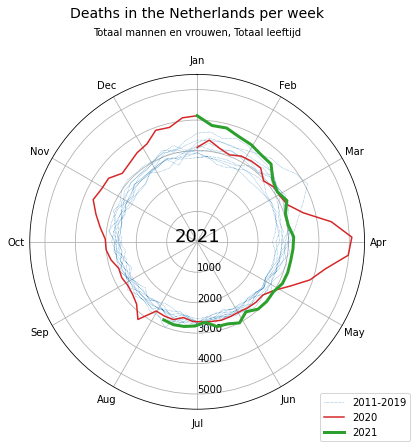

In [11]:
start_year = 2010

fig, ax = setup_polar_plot(figsize=(6, 6.2), constrained_layout=False)

# english month labels
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# nudge ax position
pos = ax.get_position()
pos.y0 -= 0.05
pos.y1 -= 0.05
pos.x0 -= 0.012
pos.x1 -= 0.012
ax.set_position(pos)

fig.suptitle("Deaths in the Netherlands per week", fontsize=14)
ax.set_title(f"{sex}, {leeftijd}", fontsize=10, y=1.1)


old, = ax.plot([], [], color='tab:blue', linewidth=0.5, linestyle='dotted', label="2011-2019")
prev, = ax.plot([], [], color='tab:red', label="2020")
current, = ax.plot([], [], color='tab:green', linewidth=3, label="2021")
center = ax.text(0, 25, "5000", horizontalalignment='center', fontsize=18)
ax.set_rmax(5500)

def year_and_week_for_index(i):
    y = start_year
    while True:
        len_year = len(deaths_per_year[y].dropna()) + 1
        if len_year > i:
            return (y, i+1)
        else:
            y += 1
            i -= (len_year-1)

def data_for_index(i):
    y, w = year_and_week_for_index(i)
    #print(y, w)
    theta, year = data_for_year(y)
    return theta[:w], year[:w]

def init():
    old.set_data([], []) 
    prev.set_data([], []) 
    current.set_data([], []) 
    center.set_text("")
    return old, prev, current, center

def animate(i):
    y = year_and_week_for_index(i)[0]

    if y > start_year:
        old_theta = np.array([])
        old_data = np.array([])
        for year in range(start_year, y-1):
            theta, data = data_for_year(year)
            old_theta = np.append(old_theta, theta)
            old_data = np.append(old_data, data)
        old.set_data(old_theta, old_data)
        prev.set_data(*data_for_year(y-1))

    current.set_data(*data_for_index(i))
    center.set_text(f"{y}")
    return old, prev, current, center

num_frames = len(df_circle)

anim = mpl.animation.FuncAnimation(fig, animate, init_func=init, frames=num_frames, interval=50, blit=True) 
anim.save('sterfte_anim.mp4', writer='ffmpeg', dpi=300, extra_args=['-vf', 'tpad=stop_mode=clone:stop_duration=5'])
#anim.save(f"img/{sex}_{leeftijd}_anim.gif", writer='imagemagick', dpi=72, fps=30, savefig_kwargs={'facecolor': 'white'})

fig.legend(loc='lower right')
plt.savefig('sterfte_anim.png', dpi=300, bbox_inches='tight', facecolor='white')
print("done")

In [12]:
import ffmpeg
(
    ffmpeg
    .input('sterfte_anim.mp4')
    .output('sterfte_anim.gif')
    .run(overwrite_output=True)
)

(None, None)